In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import sys
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
pre_path = "./data/"

In [4]:
pre_file_list = os.listdir(pre_path)
data_df = pd.DataFrame()
col_list = []
for file in pre_file_list:
    # print(file)
    tmp_path = pre_path + file
    coin_type = file.split("USDT")[0]
    tmp_df = pd.read_csv(tmp_path)
    if "ignore" not in tmp_df.columns:
        tmp_df["ignore"] = 0
    if "taker_buy_base_volume" in tmp_df.columns:
        tmp_df = tmp_df.rename(columns={'taker_buy_base_volume': 'taker_buy_volume'})
    if len(col_list) == 0 and "close" in tmp_df.columns:
        col_list = tmp_df.columns
    out = [i for i, j in zip(col_list, tmp_df.columns) if i != j]
    if len(out) != 0:
        tmp_df = pd.read_csv(tmp_path,header = None)
        tmp_df.columns = col_list
    tmp_df["coin_type"] = coin_type
    tmp_df['open_time'] = tmp_df['open_time'].apply(lambda x: x//1000)
    tmp_df['open_time'] = pd.to_datetime(tmp_df['open_time'],unit='s')
    tmp_df['close_time'] = tmp_df['close_time'].apply(lambda x: x//1000)
    tmp_df['close_time'] = pd.to_datetime(tmp_df['close_time'],unit='s')
    data_df = pd.concat([data_df,tmp_df],axis = 0, ignore_index=True)

data_df = data_df.sort_values(by=['open_time',"coin_type"], ascending=True)
data_df = data_df.reset_index(drop = True)
display(data_df)

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,coin_type
0,2022-01-01 00:00:00,1.307700,1.332800,1.307600,1.329100,1.461367e+07,2022-01-01 00:59:59,1.930024e+07,29050,7.568545e+06,9.993614e+06,0,ADA
1,2022-01-01 00:00:00,511.550000,517.850000,511.430000,517.420000,2.932202e+04,2022-01-01 00:59:59,1.509610e+07,22736,1.591227e+04,8.192958e+06,0,BNB
2,2022-01-01 00:00:00,46210.570000,46729.730000,46210.550000,46650.010000,8.957465e+03,2022-01-01 00:59:59,4.164448e+08,91267,4.777701e+03,2.221296e+08,0,BTC
3,2022-01-01 00:00:00,0.170215,0.172034,0.169855,0.171798,1.942670e+05,2022-01-01 00:59:59,3.323821e+04,68,1.177470e+05,2.011555e+04,0,DOGE
4,2022-01-01 00:00:00,3676.010000,3730.000000,3676.010000,3721.670000,4.583592e+04,2022-01-01 00:59:59,1.698204e+08,67207,2.553325e+04,9.462762e+07,0,ETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199009,2023-11-30 23:00:00,14.319000,14.410000,14.287000,14.407000,4.770194e+05,2023-11-30 23:59:59,6.848692e+06,16444,2.734755e+05,3.927484e+06,0,LINK
199010,2023-11-30 23:00:00,0.760700,0.763300,0.757600,0.762600,1.260543e+07,2023-11-30 23:59:59,9.591372e+06,18852,6.195142e+06,4.714729e+06,0,MATIC
199011,2023-11-30 23:00:00,0.000008,0.000008,0.000008,0.000008,6.430450e+07,2023-11-30 23:59:59,5.319741e+02,11,5.901253e+07,4.882095e+02,0,SHIB
199012,2023-11-30 23:00:00,59.284000,59.309000,58.953000,59.309000,8.111330e+05,2023-11-30 23:59:59,4.799254e+07,54419,4.226510e+05,2.501009e+07,0,SOL


In [5]:
list(set(data_df["coin_type"].values))

['XRP',
 'GMT',
 'ADA',
 'DOGE',
 'SOL',
 'BNB',
 'ETH',
 'BTC',
 'GALA',
 'MATIC',
 'SHIB',
 'LINK']

In [6]:

# 0) PREPARE DATA & FEATURES
# ─────────────────────────────────────────────────
# Assumes data_df loaded with columns:
# ['open_time','open','high','low','close','volume',
#  'taker_buy_volume','coin_type',...]

data_df['open_time'] = pd.to_datetime(data_df['open_time'])

# simple return
data_df['return'] = data_df.groupby('coin_type')['close'].transform(lambda x: x.pct_change())

# RSI14 and EMA14
def compute_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_up = up.rolling(window, min_periods=1).mean()
    avg_down = down.rolling(window, min_periods=1).mean()
    rs = avg_up / avg_down
    return 100 - (100 / (1 + rs))

data_df['RSI12'] = data_df.groupby('coin_type')['close'].transform(lambda s: compute_rsi(s,12))
data_df['EMA12'] = data_df.groupby('coin_type')['close'].transform(lambda s: s.ewm(span=12, adjust=False).mean())
data_df['EMA8'] = data_df.groupby('coin_type')['close'].transform(lambda s: s.ewm(span=8, adjust=False).mean())
data_df['EMA24'] = data_df.groupby('coin_type')['close'].transform(lambda s: s.ewm(span=24, adjust=False).mean())

# True range and ATR20
data_df['prev_close'] = data_df.groupby('coin_type')['close'].shift(1)
data_df['tr'] = data_df.apply(
    lambda r: max(r['high'] - r['low'],
                  abs(r['high'] - r['prev_close']),
                  abs(r['low']  - r['prev_close'])),
    axis=1
)
data_df['ATR24'] = data_df.groupby('coin_type')['tr'].transform(lambda x: x.rolling(24, min_periods=1).mean())
data_df['ATR12'] = data_df.groupby('coin_type')['tr'].transform(lambda x: x.rolling(12, min_periods=1).mean())

# Volume MA20
data_df['vol_MA24'] = data_df.groupby('coin_type')['volume'].transform(lambda x: x.rolling(24, min_periods=1).mean())
data_df['volchg'] = data_df.groupby('coin_type')['volume'].pct_change()
data_df['imm'] = (
    data_df['taker_buy_volume']
    - (data_df['volume'] - data_df['taker_buy_volume'])
) / data_df['volume']
data_df['distE']  = data_df['close'] / data_df['EMA12'] - 1


# drop missing
data_df.dropna(subset=[
    'return','high','low','close','volume',
    'RSI12','EMA12','ATR24','ATR12','vol_MA24','taker_buy_volume','volchg','imm','distE'
], inplace=True)

# 1) PIVOT TO WIDE FORM
# ─────────────────────────────────────────────────
cols = ['return','high','low','close','volume','RSI12','EMA12','EMA8','EMA24','ATR24','ATR12','vol_MA24','taker_buy_volume','volchg','imm','distE']
wide = {}
for c in cols:
    w = (
        data_df
        .pivot(index='open_time', columns='coin_type', values=c)
        .sort_index()
    )
    # 1.1) forward‐fill any gaps…
    w = w.ffill()
    # 1.2) scrub infinities → NaN → then fill with 0
    w = w.replace([np.inf, -np.inf], np.nan).fillna(0)
    # 1.3) drop any remaining rows that still have NaNs in *all* coins
    w = w.dropna(how='all')
    wide[c] = w
    
# align timestamps
idx = wide['return'].index
for c in cols:
    wide[c] = wide[c].reindex(idx).ffill().fillna(0)

# build return arrays
R      = wide['return'].values
R_next = pd.DataFrame(R, index=idx).shift(-1).values
R, R_next = R[:-1], R_next[:-1]
T, M = R.shape
times = idx[:T]

# 2) HELPERS
# ─────────────────────────────────────────────────
def risk_weights(sig, atr, gross=0.5):
    inv_vol = np.where(atr>0, 1/atr, 0)
    w_raw = sig * inv_vol
    total = np.nansum(np.abs(w_raw))
    return (w_raw/total)*gross if total>0 else np.zeros_like(w_raw)

def compute_metrics(pnl):
    avg = pnl.mean()
    std = pnl.std(ddof=0)
    sharpe = (avg/std)*np.sqrt(8760) if std>0 else np.nan
    cum = (1+pnl).cumprod()
    maxdd = (cum / cum.cummax() - 1).min()
    wins  = pnl[pnl>0]; losses = pnl[pnl<0]
    aw = wins.mean() if len(wins)>0 else np.nan
    al = losses.mean() if len(losses)>0 else np.nan
    return avg, sharpe, maxdd, aw, al



In [9]:
from sklearn.ensemble import RandomForestRegressor
results = {}

In [11]:
# METHOD 1: Rolling Ridge Regression (Threshold + vol-scaling)
# ────────────────────────────────────────────────────────────────
pnl1 = []
W1, p1, gross = 24, 0.95, 0.5
for t in range(W1, T):
    # build training set
    Xtr, ytr = [], []
    for s in range(t-W1, t):
        r_lag = R[s-1] if s-1>=0 else np.zeros(M)
        rsi   = wide['RSI12'].iloc[s].values
        volchg= wide['volchg'].iloc[s].values
        imm   = wide['imm'   ].iloc[s].values
        distE  = wide['distE' ].iloc[s].values
        Xtr.append(np.vstack([r_lag, rsi, volchg, imm, distE]).T)
        ytr.append(R_next[s])
    Xtr = np.vstack(Xtr); ytr = np.hstack(ytr)
    mdl = Ridge(alpha=1.0).fit(Xtr, ytr)
    # mdl = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    # mdl.fit(Xtr, ytr)
    # predict
    r_lag = R[t-1]; rsi = wide['RSI12'].iloc[t].values
    volchg= wide['volchg'].iloc[t].values
    imm   = wide['imm'   ].iloc[t].values
    distE = wide['distE' ].iloc[t].values
    pred  = mdl.predict(np.vstack([r_lag, rsi, volchg, imm, distE]).T)
    # threshold
    tau = np.quantile(np.abs(pred), p1)
    pred[np.abs(pred) < tau] = 0
    # weights
    atr = wide['ATR24'].iloc[t].values
    w = risk_weights(pred, atr, gross=gross)
    pnl1.append(w.dot(R_next[t]))
pnl1 = pd.Series(pnl1, index=times[W1:])
results['Method1_Imp'] = compute_metrics(pnl1)

In [12]:
# 2) METHOD 2': MA Crossover
pnl2 = []
short_w, long_w = 12, 24
threshold_q = 0.95
for t in range(long_w, T):
    price = wide['close'].iloc[t].values
    sma_short = wide['close'].iloc[t-short_w+1:t+1].mean().values
    sma_long  = wide['close'].iloc[t-long_w+1:t+1].mean().values
    diff = sma_short - sma_long
    # thresholding cross-sectionally
    tau = np.quantile(np.abs(diff), threshold_q)
    sig = np.sign(diff) * (np.abs(diff) >= tau)
    atr = wide['ATR24'].iloc[t].values
    w = risk_weights(sig, atr)
    pnl2.append(w.dot(R_next[t]))
pnl2 = pd.Series(pnl2, index=times[long_w:])
results['Method2_MA'] = compute_metrics(pnl2)

In [96]:
#COMPUTE INDICATORS
# RSI12

# Stochastic %K (12)
low12 = wide['low'].rolling(12, min_periods=1).min()
high12 = wide['high'].rolling(12, min_periods=1).max()
wide['StochK'] = (wide['close'] - low12) / (high12 - low12) * 100

# Ease of Movement (EMV) and 12-ma
mid = (wide['high'] + wide['low']) / 2
prev_mid = mid.shift(1)
wide['EMV'] = ((mid - prev_mid) * (wide['high'] - wide['low'])) / wide['volume']
wide['EMV'] = wide['EMV'].rolling(12, min_periods=1).mean()

# TRIX (12)
ema1 = wide['close'].ewm(span=12, adjust=False).mean()
ema2 = ema1.ewm(span=12, adjust=False).mean()
ema3 = ema2.ewm(span=12, adjust=False).mean()
wide['TRIX'] = (ema3 - ema3.shift(1)) / ema3.shift(1) * 100

# ADX12
prev_high = wide['high'].shift(1)
prev_low = wide['low'].shift(1)
dh = wide['high'] - prev_high
dl = prev_low - wide['low']
DMp = dh.where((dh>dl)&(dh>0), 0.0)
DMm = dl.where((dl>dh)&(dl>0), 0.0)
DMp_s = DMp.rolling(12, min_periods=1).mean()
DMm_s = DMm.rolling(12, min_periods=1).mean()
plus_DI  = 100 * (DMp_s / wide['ATR24'])
minus_DI = 100 * (DMm_s / wide['ATR24'])
DX = 100 * (abs(plus_DI - minus_DI) / (plus_DI + minus_DI).replace(0, np.nan))
wide['ADX12'] = DX.rolling(12, min_periods=1).mean().fillna(0)
wide['plus_DI'] = plus_DI.fillna(0)
wide['minus_DI'] = minus_DI.fillna(0)

# Fill any remaining NaNs
for c in ['RSI12','StochK','EMV','TRIX',"ADX12","plus_DI","minus_DI"]:
    wide[c] = wide[c].ffill().fillna(0)

In [14]:
# METHOD 3: COMBINED INDICATOR SIGNAL
pnl3 = []
gross = 0.5
for t in range(1, T):
    # Count indicator agreements
    rsi = wide['RSI12'].iloc[t].values
    stoch = wide['StochK'].iloc[t].values
    emv = wide['EMV'].iloc[t].values
    trix = wide['TRIX'].iloc[t].values
    adx   = wide['ADX12'].iloc[t].values
    plusD = plus_DI.iloc[t].values
    minusD= minus_DI.iloc[t].values
    
    # bullish = (rsi < 30).astype(int) + (stoch < 20).astype(int) + (emv > 0).astype(int) + (trix > 0).astype(int) +  ((plusD > minusD) & (adx > 25)).astype(int)
    # bearish = (rsi > 70).astype(int) + (stoch > 80).astype(int) + (emv < 0).astype(int) + (trix < 0).astype(int) +  ((minusD > plusD) & (adx > 25)).astype(int)
    bullish = (rsi < 30).astype(int) + (stoch < 20).astype(int)  + (trix > 0).astype(int) +  ((plusD > minusD) & (adx > 25)).astype(int)
    bearish = (rsi > 70).astype(int) + (stoch > 80).astype(int)  + (trix < 0).astype(int) +  ((minusD > plusD) & (adx > 25)).astype(int)

    sig = np.zeros(M)
    sig[bullish >= 3] = +1
    sig[bearish >= 3] = -1

    atr = wide['ATR24'].iloc[t].values
    w = risk_weights(sig, atr, gross=gross)
    pnl3.append(w.dot(R_next[t]))

pnl3 = pd.Series(pnl3, index=times[1:])
results['Method3_MultiInd'] = compute_metrics(pnl3)

In [98]:
# 4) GENERATE SIGNALS
# ───────────────────────────────────────────────────
indicators = ['RSI12','StochK','EMV','TRIX','ADX12']
signals = {ind: np.zeros((T, M)) for ind in indicators}
for ind in indicators:
    arr = wide[ind].values
    if ind == 'RSI12':
        signals[ind] = np.where(arr < 30, 1, np.where(arr > 70, -1, 0))
    elif ind == 'StochK':
        signals[ind] = np.where(arr < 20, 1, np.where(arr > 80, -1, 0))
    elif ind == 'EMV':
        signals[ind] = np.where(arr > 0, 1, np.where(arr < 0, -1, 0))
    elif ind == 'TRIX':
        signals[ind] = np.where(arr > 0, 1, np.where(arr < 0, -1, 0))
    elif ind == 'ADX12':
        pDI = wide['plus_DI'].values
        mDI = wide['minus_DI'].values
        signals[ind] = np.where((pDI>mDI)&(wide['ADX12']>25), 1,
                                np.where((mDI>pDI)&(wide['ADX12']>25), -1, 0))

# 5) EWMA ACCURACY
# ───────────────────────────────────────────────────
window_acc = 24
alpha = 0.3
accuracy = {ind: np.zeros(T) for ind in indicators}
for ind in indicators:
    corr_ewma = 0.0
    for t in range(1, T):
        # correct signals at t-1
        sig = signals[ind][t-1]
        ret = R_next[t-1]
        correct = 1.0 if np.any((sig * ret) > 0) else 0.0
        corr_ewma = alpha * correct + (1-alpha) * corr_ewma
        accuracy[ind][t] = corr_ewma

# Normalize accuracy to [0.5,0.9]
for ind in indicators:
    accuracy[ind] = np.clip(accuracy[ind], 0.5, 0.9)

# 6) REGIME: cross‐sectional realized vol
# ───────────────────────────────────────────────────
realized_vol_cs = wide['return'].rolling(20, min_periods=1).std().mean(axis=1).values
median_vol = np.nanmedian(realized_vol_cs)
# determine regime weights multipliers
w_mom_factor = np.where(realized_vol_cs > median_vol, 1.25, 1.0)
w_rev_factor = np.where(realized_vol_cs <= median_vol, 1.25, 1.0)


In [102]:
# METHOD 4: SOFT‐VOTING WITH THRESHOLD & VOLUME FILTER
# ───────────────────────────────────────────────────
pnl4 = []
gross = 0.5
theta = 0.3  # minimum aggregate score to trade

for t in range(1, T):
    # weighted soft vote
    score = np.zeros(M)
    for ind in indicators:
        weight = accuracy[ind][t] * (w_mom_factor[t] if ind in ['RSI12','TRIX'] else w_rev_factor[t])
        score += weight * signals[ind][t]
    # threshold small scores
    score[np.abs(score) < theta] = 0
    # volume filter
    vol_t = wide['volume'].iloc[t].values
    vol_ma = wide['vol_MA24'].iloc[t].values
    score[vol_t <= 1.2 * vol_ma] = 0
    # ADX gate
    adx_t = wide['ADX12'].iloc[t].values
    score[adx_t <= 25] = 0

    atr_t = wide['ATR24'].iloc[t].values
    w = risk_weights(score, atr_t, gross=gross)
    pnl4.append(w.dot(R_next[t]))

# 9) EVALUATE
pnl4 = pd.Series(pnl4, index=times[1:])
results['Method4_Multind_acc'] = compute_metrics(pnl4)

                       AvgRet    Sharpe   MaxDraw    AvgWin   AvgLoss
Method1_Imp          0.000076  1.229145 -0.388967  0.003510 -0.003417
Method2_MA           0.000073  2.301687 -0.193199  0.001852 -0.001677
Method3_MultiInd     0.000038  1.260652 -0.331017  0.002837 -0.003256
Method4_Multind_acc  0.000070  1.243538 -0.539032  0.004112 -0.003520


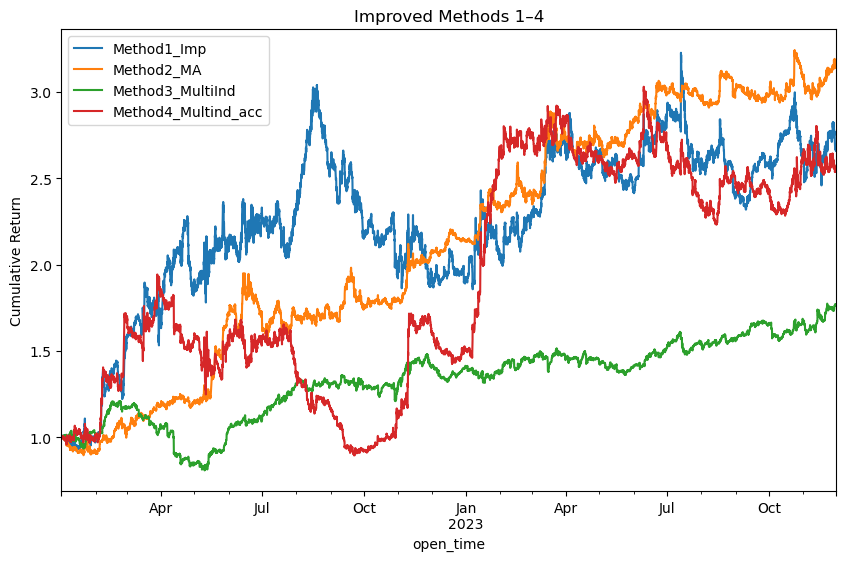

In [106]:
# 8) SUMMARIZE & PLOT
# ─────────────────────────────────────────────────
metrics_df = pd.DataFrame.from_dict(
    results, orient='index',
    columns=['AvgRet','Sharpe','MaxDraw','AvgWin','AvgLoss']
)
print(metrics_df)

plt.figure(figsize=(10,6))
for name, series in zip(metrics_df.index, [pnl1,pnl2, pnl3,pnl4]):
    (1+series).cumprod().plot(label=name)
plt.legend(); plt.title("Improved Methods 1–4"); plt.ylabel("Cumulative Return"); plt.show()